<a href="https://colab.research.google.com/github/saivarshitnune/Diabetic-retinory-image-classification/blob/Varshith/Diabetic_retinoapthy_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import os

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d pkdarabi/diagnosis-of-diabetic-retinopathy

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/diagnosis-of-diabetic-retinopathy
License(s): Attribution 4.0 International (CC BY 4.0)
diagnosis-of-diabetic-retinopathy.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/diagnosis-of-diabetic-retinopathy.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = "/content/train"
test_dir = "/content/test"
val_dir = "/content/valid"

In [ ]:
# Define image size
img_width, img_height = 224, 224

In [ ]:
# Create image data generators
train_datagen = ImageDataGenerator(
                rotation_range=45,
                rescale=1./255,
                # zoom_range=0.5,
                horizontal_flip=True,
                vertical_flip=True
                )
val_datagen = ImageDataGenerator(
                rotation_range=45,
                rescale=1./255,
                # zoom_range=0.5,
                horizontal_flip=True,
                vertical_flip=True
                )

In [ ]:
# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode="binary",
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode="binary",
)

Found 2076 images belonging to 2 classes.
Found 531 images belonging to 2 classes.


In [ ]:
# Load VGG16 model with weights pre-trained on ImageNet
base_model = VGG16(include_top=False, weights="imagenet", input_shape=(img_width, img_height, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add two fully-connected layers
x = Flatten()(base_model.output)
x = Dense(128, activation="relu")(x)
x= Dense(64,activation='relu')(x)
predictions = Dense(1, activation="sigmoid")(x)

In [ ]:
# Create the model
model1 = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model
model1.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001) ,metrics=['Accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [ ]:
ckpt_filename= "/content/drive/MyDrive/weightFiles"
checkpoint = ModelCheckpoint(filepath=ckpt_filename+'/'+'model_epoch_{epoch:02d}.h5', save_best_only=True, save_freq='epoch',save_weights_only=True,verbose = 1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1)#
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='min', verbose = 1)

In [ ]:
# # Train the model
history=model1.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32,
    callbacks=[checkpoint, lr_reduce, early_stop]
)

Epoch 1/100
64/64 [==============================] - ETA: 0s - loss: 0.3041 - Accuracy: 0.8757
Epoch 1: val_loss improved from inf to 0.21911, saving model to /content/drive/MyDrive/weightFiles/model_epoch_01.h5
64/64 [==============================] - 51s 637ms/step - loss: 0.3041 - Accuracy: 0.8757 - val_loss: 0.2191 - val_Accuracy: 0.9141 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 0.2262 - Accuracy: 0.9139
Epoch 2: val_loss improved from 0.21911 to 0.19670, saving model to /content/drive/MyDrive/weightFiles/model_epoch_02.h5
64/64 [==============================] - 37s 583ms/step - loss: 0.2262 - Accuracy: 0.9139 - val_loss: 0.1967 - val_Accuracy: 0.9121 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - ETA: 0s - loss: 0.1921 - Accuracy: 0.9291
Epoch 3: val_loss improved from 0.19670 to 0.18103, saving model to /content/drive/MyDrive/weightFiles/model_epoch_03.h5
64/64 [==============================] - 37s 583ms/step - 

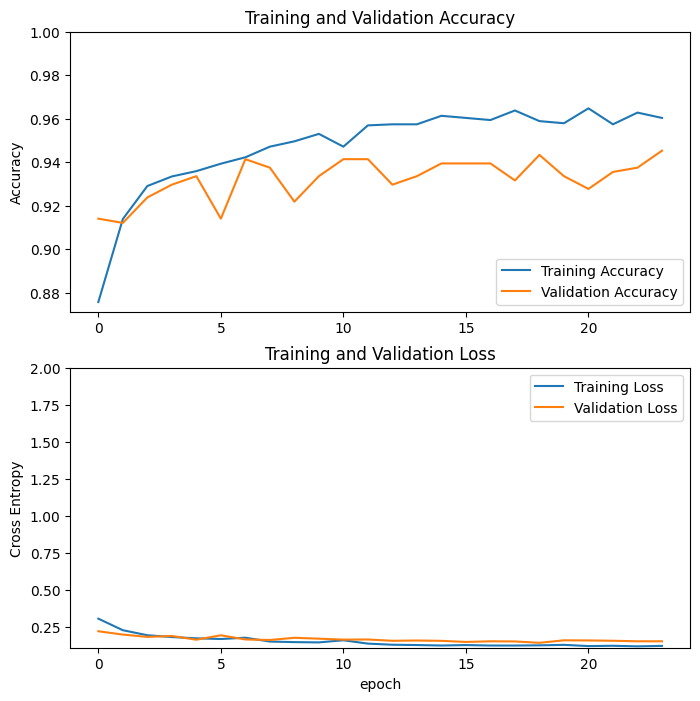

In [ ]:
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Evaluate the model on the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode="binary",
    shuffle = False
)

Found 231 images belonging to 2 classes.


In [ ]:
loss, accuracy = model1.evaluate(test_generator, steps=test_generator.samples // 32)

7/7 [==============================] - 1s 123ms/step - loss: 0.1238 - Accuracy: 0.9554


In [ ]:
# Predict on the test data
predictions = model1.predict(test_generator)

8/8 [==============================] - 3s 437ms/step


In [ ]:
y_true = test_generator.classes

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)

# Calculate AUC
auc_score = auc(fpr, tpr)

# Find the threshold maximizing Youden's J statistic
max_j_idx = np.argmax(tpr - fpr)
optimal_thresh = thresholds[max_j_idx]

print("AUC:", auc_score)
print("Optimal threshold:", optimal_thresh)

AUC: 0.9880005999700016
Optimal threshold: 0.6342453


In [ ]:
y_pred = (predictions > optimal_thresh ).astype("int32")

In [ ]:
# Generate classification report and confusion matrix
print("Classification report:")
print(classification_report(y_true, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       113
           1       0.96      0.97      0.96       118

    accuracy                           0.96       231
   macro avg       0.96      0.96      0.96       231
weighted avg       0.96      0.96      0.96       231



In [ ]:
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

Confusion matrix:
[[108   5]
 [  4 114]]


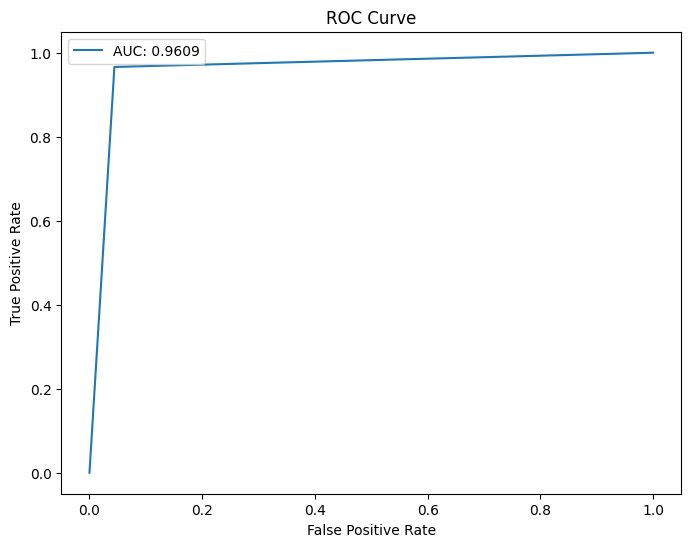

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Calculate the AUC
auc_score = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC: {auc_score:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

**Test Accuracy for VGG16 model is found to be 95.54%**

In [ ]:
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.9554


Analyzing Missclassifications of data


In [ ]:
images = test_generator.filepaths

In [ ]:
import pandas as pd
df = pd.DataFrame(images,columns=['Test_images'])

In [ ]:
df

,Test_images
0,/content/test/DR/00cb6555d108_png.rf.29cca1709...
1,/content/test/DR/0104b032c141_png.rf.2b861f09f...
2,/content/test/DR/03747397839f_png.rf.b634cf9fb...
3,/content/test/DR/04d029cfb612_png.rf.d9cf2e2a4...
4,/content/test/DR/0ada12c0e78f_png.rf.3e8e491a2...
...,...
226,/content/test/No_DR/fca1a8738b8a_png.rf.539925...
227,/content/test/No_DR/fcc32dffd24d_png.rf.794c1f...
228,/content/test/No_DR/fd0a70082e7c_png.rf.c488e8...
229,/content/test/No_DR/fe06dad6851c_png.rf.fa9183...


In [ ]:
df['True_labels'] = y_true

In [ ]:
df['Predictions'] = y_pred

In [ ]:
df

,Test_images,True_labels,Predictions
0,/content/test/DR/00cb6555d108_png.rf.29cca1709...,0,0
1,/content/test/DR/0104b032c141_png.rf.2b861f09f...,0,0
2,/content/test/DR/03747397839f_png.rf.b634cf9fb...,0,0
3,/content/test/DR/04d029cfb612_png.rf.d9cf2e2a4...,0,0
4,/content/test/DR/0ada12c0e78f_png.rf.3e8e491a2...,0,0
...,...,...,...
226,/content/test/No_DR/fca1a8738b8a_png.rf.539925...,1,1
227,/content/test/No_DR/fcc32dffd24d_png.rf.794c1f...,1,1
228,/content/test/No_DR/fd0a70082e7c_png.rf.c488e8...,1,1
229,/content/test/No_DR/fe06dad6851c_png.rf.fa9183...,1,1


In [ ]:
df['New'] = df.apply(lambda x: 1 if x['True_labels'] !=
                     x['Predictions'] else np.nan, axis=1)

In [ ]:
df = df.dropna()

In [ ]:

df = df.drop(['True_labels','Predictions','New'], axis = 1)

In [ ]:
df

,Test_images
38,/content/test/DR/513b0a4651fa_png.rf.7eca236b8...
78,/content/test/DR/a443c4fd489c_png.rf.05837dd6c...
95,/content/test/DR/d3be5346684b_png.rf.e6dd8f384...
98,/content/test/DR/d5b4705ac2ee_png.rf.8d2f70d09...
108,/content/test/DR/f3a88d3026dc_png.rf.4355ca512...
139,/content/test/No_DR/3732de8b416f_png.rf.2c6359...
159,/content/test/No_DR/7ad0c4975890_png.rf.be6cbc...
164,/content/test/No_DR/7eee3d1f1268_png.rf.5b5a84...
187,/content/test/No_DR/ae5d31979f19_png.rf.3e1acc...


In [ ]:
len(df)

9

In [ ]:
# Convert data frame to list
Miss_classified_images = df['Test_images'].values.tolist()


In [ ]:
Miss_classified_images

['/content/test/DR/513b0a4651fa_png.rf.7eca236b8673dbf5f85efadc0887c26c.jpg',
 '/content/test/DR/a443c4fd489c_png.rf.05837dd6c0653d027484e1b79086c9a4.jpg',
 '/content/test/DR/d3be5346684b_png.rf.e6dd8f384ecb31e9f62636af2120d259.jpg',
 '/content/test/DR/d5b4705ac2ee_png.rf.8d2f70d09d373d9f329dbffdcc9e5c40.jpg',
 '/content/test/DR/f3a88d3026dc_png.rf.4355ca512a17a5ba9dc838250fd8b856.jpg',
 '/content/test/No_DR/3732de8b416f_png.rf.2c635982c9bf7383b0234591ad76e36c.jpg',
 '/content/test/No_DR/7ad0c4975890_png.rf.be6cbc9236535e912e8ae94da5456440.jpg',
 '/content/test/No_DR/7eee3d1f1268_png.rf.5b5a84f2995b018d738fdc6391ed3c9f.jpg',
 '/content/test/No_DR/ae5d31979f19_png.rf.3e1accfc85329e3347ba1d5d966bec6d.jpg']

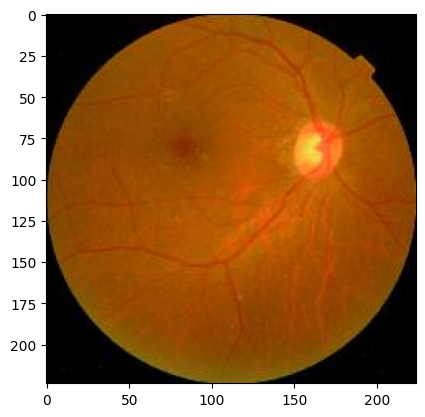

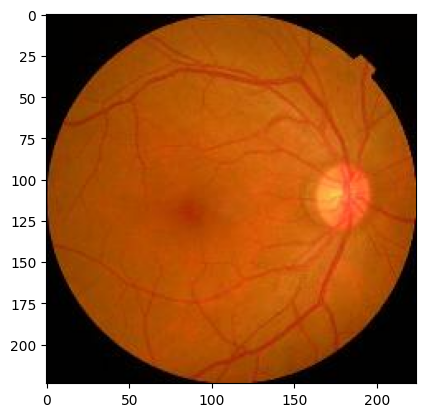

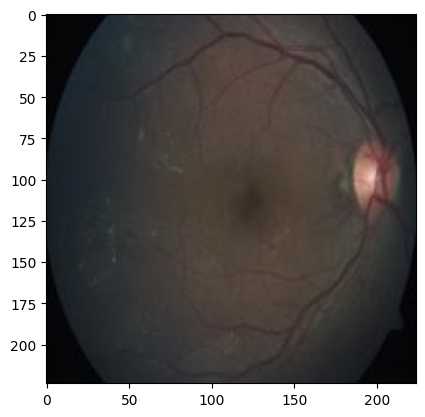

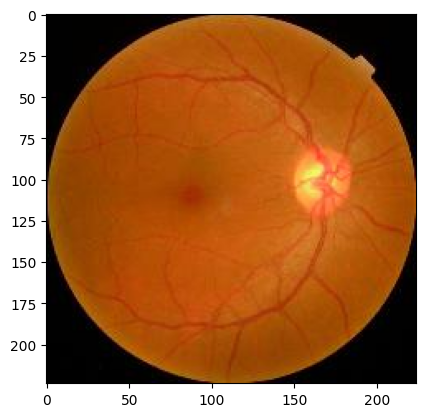

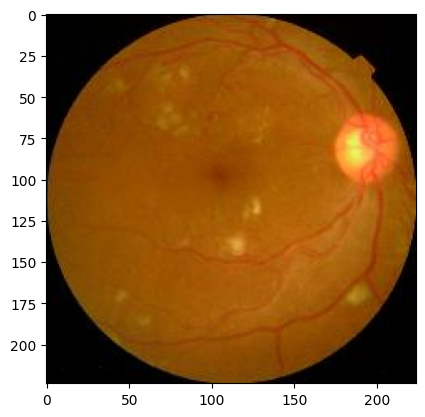

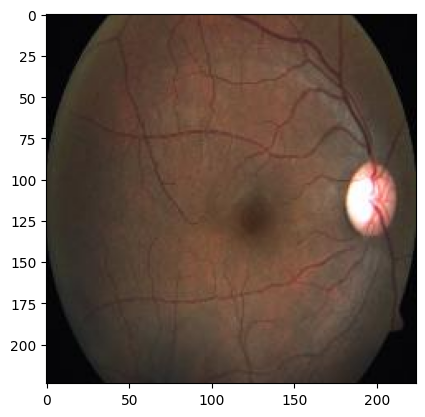

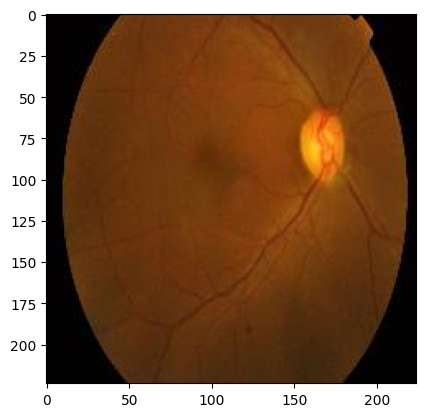

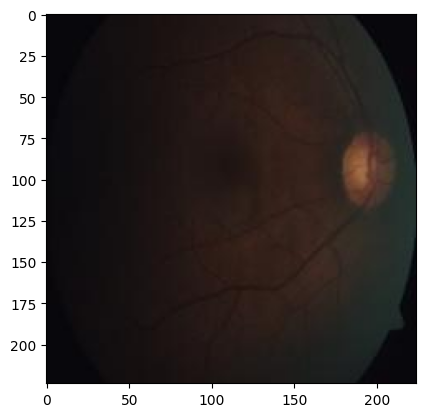

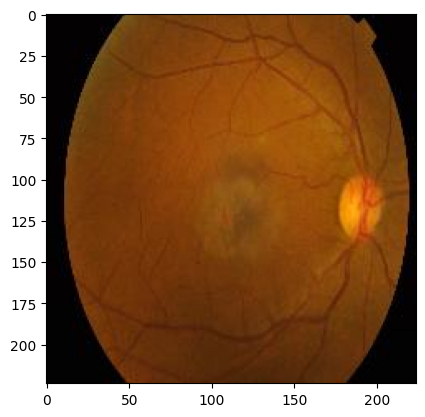

In [ ]:
import cv2
import numpy as np
from PIL import Image
for i in Miss_classified_images:
  img = Image.open(i)
  plt.imshow(img)
  plt.show()

Conclusion :-
If you observe the miss classified images most of them are bluish colour which is different from the majority of images and also black spots on the images . So due to incorrect data there are few miss classified predictions.